# Machine Learning on Parking Space Occupancy in Dresden

Can we predict the occupation of a parking space ([Centrum-Galerie](https://www.bing.com/maps/default.aspx?q=centrum+galerie+dresden&mkt=de&FORM=HDRSC4)) in Dresden?

Read about it here: http://mechlab-engineering.de/2015/03/vorhersage-der-parkhausbelegung-mit-offenen-daten/

In [1]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

pd.options.mode.chained_assignment = None  # default='warn'

Take the historical data from https://parkendd.de/dumps/

### Read the data and process it

In [2]:
name = 'Centrum Galerie'

In [3]:
url_2016 = 'https://parkendd.de/dumps/dresdencentrumgalerie-2016.csv'
url_2017 = 'https://parkendd.de/dumps/dresdencentrumgalerie-2017.csv'
url_2018 = 'https://parkendd.de/dumps/dresdencentrumgalerie-2018.csv'

In [4]:
data_2016 = pd.read_csv(url_2016, names=['Datum','free'], index_col='Datum', parse_dates=True)
data_2017 = pd.read_csv(url_2017, names=['Datum','free'], index_col='Datum', parse_dates=True)
data_2018 = pd.read_csv(url_2018, names=['Datum','free'], index_col='Datum', parse_dates=True)

data = pd.concat([data_2016, data_2017, data_2018])
data.sort_index(inplace=True)

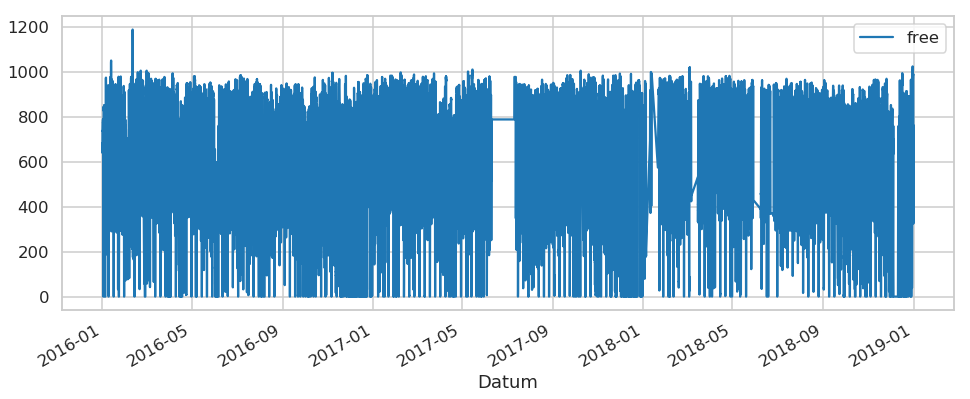

In [5]:
data.plot(figsize=(16,6));

In [6]:
data = data.dropna()

In [7]:
data.isna().sum()

free    0
dtype: int64

Calc the occupation ([ger] Belegung)

In [8]:
data['Belegung'] = 100.0-(data.free/950.0*100.0)
data['Belegung'] = data['Belegung'].astype(int)
data.drop('free', axis=1, inplace=True)

# Predict for the `parkingspot`

Ok, take a look at the TimeSeries

In [9]:
# function to plot timeseries with weekend
def plotbelegung(df, which, fromdate, todate):
    if fromdate=='':
        fromdate=df.index[0]
    if todate=='':
        todate=df.index[-1]

    weekend = df[fromdate:todate].index[df[fromdate:todate].index.weekday>4]
    ax = df[fromdate:todate].plot(figsize=(16,6), ylim=(0, 120),
                                  alpha=0.9, rot=0,
                                  title='Auslastung Parkplatz \'%s\' Dresden %s bis %s' % (which, fromdate, todate))
    
    if not df.index.freqstr: # Wenn DataFrame keine Frequenz hat
        ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0,1,2,3,4,5,6),interval=1))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d.'))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\nSa/So'))
        ax.xaxis.grid(True, which="minor")
        ax.xaxis.grid(False, which="major")
    
    plt.ylabel('%')
    
    for w in weekend[::10]:
        plt.axvline(w, c='k', alpha=0.08, zorder=-1)
        
    return plt

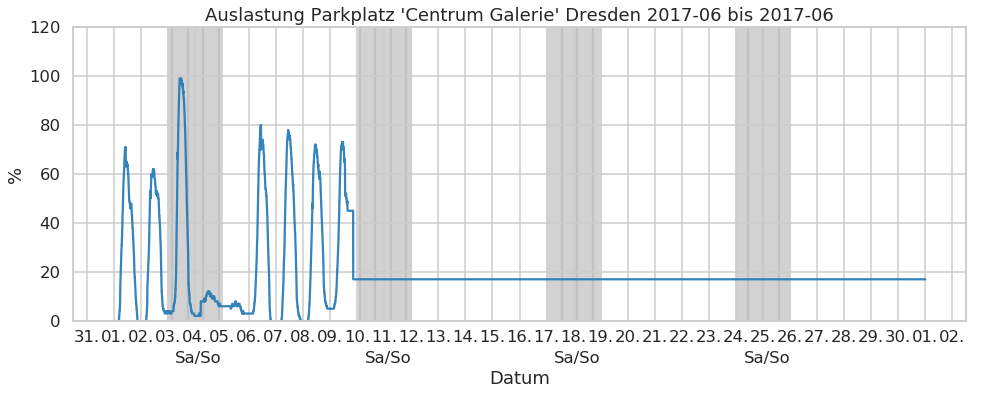

In [10]:
plotbelegung(data['Belegung'], name, '2017-06', '2017-06');

# Let's do some Machine Learning on that

## Features

* Uhrzeit
* Wochentag
* Monat
* Verkaufsoffener Sonntag?
* nächster Tag Feiertag? (Deutschland)
* übernächster Tag auch noch Feiertag? (Deutschland)
* Ferien (Deutschland)
* spezielles Event in Galerien oder Stadt oder Kultur
* nächster Tag Feiertag? (Tschechien)
* übernächster Tag auch noch Feiertag? (Tschechien)
* Ferien (Tschechien)
* Wetter

Wir haben nicht alle Features. Aber wenigstens die wichtigsten.

In [11]:
def norm(x):
    return (x - x.mean()) / x.std()

### Wochentag

Es ist wichtig, ob Montag oder Samstag oder Sonntag ist.

In [12]:
data['Wochentag'] = data.index.dayofweek

In [13]:
# Normieren
data['Wochentag'] = norm(data['Wochentag'])

### Uhrzeit

Dann ist es natürlich extrem wichtig, ob es in der Nacht ist oder tagsüber.

In [14]:
data['Uhrzeit'] = data.index.hour*60.0 + data.index.minute

In [15]:
# Normieren
data['Uhrzeit'] = norm(data['Uhrzeit'])

### Verkaufsoffener Sonntage

In [16]:
offeneSonntage = ['2016-12-04', '2017-12-10', '2018-12-09']

In [17]:
data['offenerSonntag'] = 0
for os in offeneSonntage:
    data['offenerSonntag'].loc[os] = 1

### Feiertage

Wenn ein Feiertag naht, dann gehen auch mehr Leute in die Stadt. Genauso nach einem Feiertag. Deshalb ist das ein Feature.

Get them from http://www.feiertage.net/frei-tage.php

In [18]:
feiertage = pd.DataFrame()
for year in range(2016, 2020):
    feiertage = feiertage.append(pd.read_csv('Sachsen%i.csv' % year, index_col=0, parse_dates=True, sep=';', dayfirst=True))

In [19]:
feiertage

,Feiertage,Bundesland
Tag,,
2016-01-01,Neujahr,Sachsen
2016-03-25,Karfreitag,Sachsen
2016-03-28,Ostermontag,Sachsen
2016-05-01,Maifeiertag,Sachsen
2016-05-05,Christi Himmelfahrt,Sachsen
2016-05-16,Pfingstmontag,Sachsen
2016-05-26,Fronleichnam,Sachsen
2016-10-03,Tag der Deutschen Einheit,Sachsen
2016-10-31,Reformationstag,Sachsen


Mit [numpy.busday_count](http://docs.scipy.org/doc/numpy/reference/generated/numpy.busday_count.html) bekommen wir die Anzahl der Werktage bis zum nächsten Feiertag, weil die Leute ja vor einem langen Wochenende immer noch mal richtig einkaufen gehen.

In [20]:
def shoppingdaystonextfeiertag(df):
    diffs = []
    for feiertag in feiertage.index:
        diff = np.busday_count(df.date(), feiertag.date(), weekmask='Mon Tue Wed Thu Fri Sat')
        #print('%s bis %s: %i Arbeitstage' % (feiertag, df, diff)) 
        diffs.append(diff)
        
    try:
        return min([d for d in diffs if d>=0])
    except:
        return 100 # wenn kein Feiertag gefunden

In [21]:
#feiertagseries = pd.Series(data.index, name='Feiertage', index=data.index).apply(shoppingdaystonextfeiertag)
#data['bisFeiertag'] = feiertagseries

In [22]:
def shoppingdaysafterfeiertag(df):
    diffs = []
    for feiertag in feiertage.index:
        diff = np.busday_count(feiertag.date(), df.date(), weekmask='Mon Tue Wed Thu Fri Sat')
        #print('%s bis %s: %i Arbeitstage' % (feiertag, df, diff)) 
        diffs.append(diff)
        
    try:
        return min([d for d in diffs if d>=0])
    except:
        return 100 # wenn kein Feiertag gefunden

In [23]:
#feiertagseries = pd.Series(data.index, name='Feiertage', index=data.index).apply(shoppingdaysafterfeiertag)
#data['nachFeiertag'] = feiertagseries

### Schulferien

Schulferien Sachsen: http://www.schulferien.org/Sachsen/sachsen.html

In [24]:
schulferien = [['2016-02-08','2016-02-19'],
               ['2016-03-25','2016-04-01'],
               ['2016-06-27','2016-08-05'],
               ['2016-10-03','2016-10-15'],
               ['2017-02-13','2017-02-24'],
               ['2017-04-13','2017-04-22'],
               ['2017-05-25','2017-05-26'],
               ['2017-06-26','2017-08-04'],
               ['2017-10-02','2017-10-14'],
               ['2017-10-30','2017-10-31'],
               ['2017-12-23','2018-01-02'],
               ['2018-02-12','2018-02-23'],
               ['2018-03-29','2018-04-06'],
               ['2018-05-19','2018-05-22'],
               ['2018-07-02','2018-08-10'],
               ['2018-10-08','2018-10-20'],
               ['2018-12-22','2019-01-04']]

In [25]:
data['Schulferien'] = 0
for sf in schulferien:
    data['Schulferien'].loc[sf[0]:sf[1]]= 1

### Weihnachten

Tage bis Weihnachten, weil das so ein wichtiges Datum ist

In [26]:
data['Weihnachten'] = -(data.index.dayofyear - 358)

In [27]:
# Normieren
data['Weihnachten'] = norm(data['Weihnachten'])

### Check

In [28]:
data.head()

,Belegung,Wochentag,Uhrzeit,offenerSonntag,Schulferien,Weihnachten
Datum,,,,,,
2016-01-01 00:00:10,32,0.496421,-1.726996,0,0,1.774433
2016-01-01 00:05:06,32,0.496421,-1.714965,0,0,1.774433
2016-01-01 00:10:03,32,0.496421,-1.702935,0,0,1.774433
2016-01-01 00:15:05,31,0.496421,-1.690905,0,0,1.774433
2016-01-01 00:20:11,31,0.496421,-1.678875,0,0,1.774433


In [29]:
data.describe()

,Belegung,Wochentag,Uhrzeit,offenerSonntag,Schulferien,Weihnachten
count,302533.000000,3.025330e+05,3.025330e+05,302533.000000,302533.000000,3.025330e+05
mean,30.141033,-1.297346e-15,-1.295689e-16,0.001907,0.235895,-1.568467e-14
std,30.408021,1.000000e+00,1.000000e+00,0.043630,0.424558,1.000000e+00
min,-25.000000,-1.499350e+00,-1.726996e+00,0.000000,0.000000,-1.727086e+00
25%,5.000000,-1.000407e+00,-8.608217e-01,0.000000,0.000000,-8.636978e-01
50%,17.000000,-2.521654e-03,5.352188e-03,0.000000,0.000000,-1.949608e-02
75%,54.000000,9.953641e-01,8.715260e-01,0.000000,0.000000,8.630784e-01
max,100.000000,1.494307e+00,1.735294e+00,1.000000,1.000000,1.774433e+00


In [30]:
data.groupby([data.index.year, data.index.month, data.index.day]).first()

Belegung  Wochentag   Uhrzeit  offenerSonntag  Schulferien  \
Datum Datum Datum                                                               
2016  1     1            32   0.496421 -1.726996               0            0   
            2            17   0.995364 -1.726996               0            0   
            3            11   1.494307 -1.726996               0            0   
            4            11  -1.499350 -1.726996               0            0   
            5           100  -1.000407 -1.726996               0            0   
            6            -2  -0.501465 -1.726996               0            0   
            7             6  -0.002522 -1.726996               0            0   
            8            10   0.496421 -1.726996               0            0   
            9             1   0.995364 -1.726996               0            0   
            10            7   1.494307 -1.726996               0            0   
            11            2  -1.499350 -1.726996               0            0   
            12           -2  -1.000407 -1.726996               0            0   
            13          -10  -0.501465 -1.726996               0            0   
            14           -1  -0.002522 -1.726996               0            0   
            15            0   0.496421 -1.726996               0            0   
            16            5   0.995364 -1.726996               0            0   
            17           12   1.494307 -1.726996               0            0   
            18            4  -1.499350 -1.726996               0            0   
            19            0  -1.000407 -1.726996               0            0   
            20            6  -0.501465 -1.726996               0            0   
            21            6  -0.002522 -1.726996               0            0   
            22            6   0.496421 -1.726996               0            0   
            23           -2   0.995364 -1.726996               0            0   
            24           47   1.494307 -1.726996               0            0   
            25           41  -1.499350 -1.726996               0            0   
            26           -3  -1.000407 -1.726996               0            0   
            27            6  -0.501465 -1.726996               0            0   
            28            6  -0.002522 -1.726996               0            0   
            29            7   0.496421 -1.726996               0            0   
            30            2   0.995364 -1.726996               0            0   
...                     ...        ...       ...             ...          ...   
2018  11    27           31  -1.000407 -1.726996               0            0   
            28           13  -0.501465 -1.726996               0            0   
            29           35  -0.002522 -1.726996               0            0   
            30           27   0.496421 -1.726996               0            0   
      12    1            10   0.995364 -1.722183               0            0   
            2            14   1.494307 -1.726996               0            0   
            3            12  -1.499350 -1.726996               0            0   
            4            26  -1.000407 -1.726996               0            0   
            10          100  -1.499350 -0.018708               0            0   
            11           24  -1.000407 -1.726996               0            0   
            12           16  -0.501465 -1.726996               0            0   
            13            0  -0.002522 -1.726996               0            0   
            14            3   0.496421 -1.726996               0            0   
            15            3   0.995364 -1.726996               0            0   
            16            1   1.494307 -1.726996               0            0   
            17            8  -1.499350 -1.726996               0            0   
            18            4  -1.000407 -1.726996  

OK, nun haben wir Labels und Features fertig.

Nun können wir Test und Trainingsdatensatz erstellen.

## Train a Tensorflow Regressor

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.12.0


In [32]:
# Make a copy
dataset = data.copy()

### Split into test and training set

To get an accuracy score, we need to split our dataset in a training and a test set. We train with the training set and test the model later with the part of the test set.

In [33]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [34]:
train_labels = train_dataset.pop('Belegung')
test_labels = test_dataset.pop('Belegung')

In [35]:
train_dataset.shape

(242026, 5)

In [36]:
train_labels.shape

(242026,)

### Create the Model

In [37]:
inputs = len(train_dataset.keys())

In [38]:
def build_model():
    model = keras.Sequential([
        layers.Dense(8*inputs, activation=tf.nn.relu, input_shape=[inputs, ]),
        layers.Dense(8*inputs, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [39]:
regression_model = build_model()

In [40]:
regression_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [41]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [42]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [43]:
EPOCHS = 100

# Train with Early Stopping, if no progress
history = regression_model.fit(train_dataset,
                               train_labels,
                               epochs=EPOCHS, validation_split=0.2, verbose=0,
                               callbacks=[early_stop, PrintDot()])


....................................................................................................

In [44]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [45]:
def plot_history(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [%]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error', alpha=0.3)
    plt.legend()
    #plt.ylim([0,100])

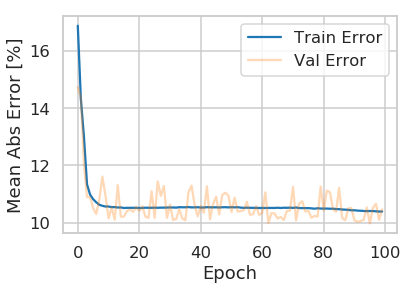

In [46]:
plot_history(hist)

In [47]:
loss, mae, mse = regression_model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}%% Belegung".format(mae))

Testing set Mean Abs Error: 10.62%% Belegung


### Let's take a look at the confusion matrix

In [48]:
test_predictions = regression_model.predict(test_dataset).flatten()

In [49]:
def plot_confusion_matrix(test_predictions, test_labels):
    plt.figure(figsize=(8,8))
    plt.scatter(test_predictions, test_labels, alpha=0.05)
    plt.plot([-10, 110], [-10, 110], c='k', lw=50, alpha=0.1)
    plt.ylabel(u'Gemessene Belegung in %')
    plt.xlabel(u'Vorhergesagte Belegung in %')
    plt.axis('equal')
    plt.axis('square')
    plt.title('Confusion Matrix Vorhersage Parkhaus Centrum Galerie Dresden Auslastung', fontsize=12)
    plt.xlim([-10, 110])
    plt.ylim([-10, 110]);
    return plt

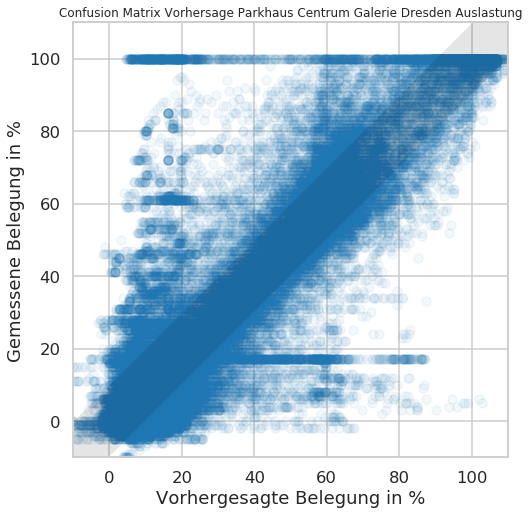

In [50]:
plt = plot_confusion_matrix(test_predictions, test_labels);
plt.savefig('%s-Belegung-Vorhersage-2019-CM.png' % name, dpi=150)

As you can see, the confusion matrix looks pretty good. That's not perfect, but take into account, that we just have a few features for such a complex scenario like inner-city parking space occupation.

## Save the model

In [51]:
# Save entire model to a HDF5 file
regression_model.save('./Models/regression_model.h5')

# Predict

Here we predict it for the whole generic dataset

## Generate the Features

In [55]:
train_dataset.keys()

Index(['Wochentag', 'Uhrzeit', 'offenerSonntag', 'Schulferien', 'Weihnachten'], dtype='object')

In [56]:
dataset = pd.DataFrame(index=pd.date_range('2016-01-01', '2019-01-01', freq='15min', closed='left'))
dataset.index.name = 'Datum'

# Create the Features
# 1.
dataset['Wochentag'] = dataset.index.dayofweek
dataset['Wochentag'] = norm(dataset['Wochentag'])

# 2.
dataset['Uhrzeit'] = dataset.index.hour#*60.0 + dataset.index.minute
dataset['Uhrzeit'] = norm(dataset['Uhrzeit'])

# 3.
dataset['offenerSonntag'] = 0
for os in offeneSonntage:
    dataset['offenerSonntag'].loc[os] = 1

# 4.
dataset['Schulferien'] = 0
for sf in schulferien:
    data['Schulferien'].loc[sf[0]:sf[1]] = 1

# 5.
dataset['Weihnachten'] = -(dataset.index.dayofyear - 358)
dataset['Weihnachten'] = norm(dataset['Weihnachten'])

## Ask the model for predictions

In [57]:
dataset['Vorhersage'] = regression_model.predict(dataset)

## Visualize the Prediction Results for every Month

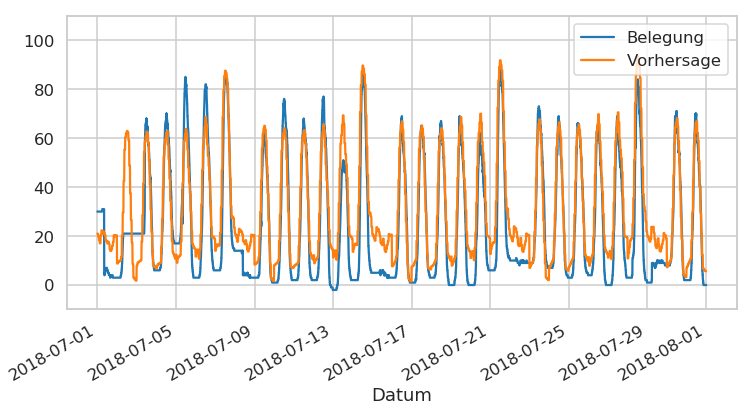

In [58]:
ax = data.loc['2018-07']['Belegung'].plot(figsize=(12, 6), label='Belegung')
dataset.loc['2018-07']['Vorhersage'].plot(ax=ax, label='Vorhersage')
ax.set_ylim([-10, 110])
ax.legend();

In [59]:
for y in ['2016', '2017', '2018']:
    for m in range(1, 13):
        ax = data.loc['%s-%02d' % (y,m)]['Belegung'].plot(figsize=(12, 6), label='Belegung')
        dataset.loc['%s-%02d' % (y,m)]['Vorhersage'].plot(ax=ax, label='Vorhersage')
        ax.set_ylim([-10, 110])
        ax.legend();
        plt.savefig('./Monatsbelegungen/%s-%s-%02d.png' % (name, y, m), dpi=150)
        plt.close()

Nun können wir vergleichen, wie die Vorhersage und die tatsächliche Belegung korrelieren.

# If we want to predict the future, let's create it

In [62]:
future = pd.DataFrame(index=pd.date_range('2019-01-01', '2020-01-01', freq='15min', closed='left'))
future.index.name = 'Datum'

# Create the Features
# 1.
future['Wochentag'] = future.index.dayofweek
future['Wochentag'] = norm(future['Wochentag'])

# 2.
future['Uhrzeit'] = future.index.hour#*60.0 + future.index.minute
future['Uhrzeit'] = norm(future['Uhrzeit'])

# 3.
future['offenerSonntag'] = 0
for os in offeneSonntage:
    future['offenerSonntag'].loc[os] = 1

# 4.
future['Schulferien'] = 0
for sf in schulferien:
    data['Schulferien'].loc[sf[0]:sf[1]] = 1

# 5.
future['Weihnachten'] = -(future.index.dayofyear - 358)
future['Weihnachten'] = norm(future['Weihnachten'])

### And predict the occupancy of the parking-space `Centrum-Galerie` with the future features

In [63]:
future['Vorhersage'] = regression_model.predict(future)

In [64]:
future.head()

,Wochentag,Uhrzeit,offenerSonntag,Schulferien,Weihnachten,Vorhersage
Datum,,,,,,
2019-01-01 00:00:00,-0.99725,-1.661301,0,0,1.727287,5.763330
2019-01-01 00:15:00,-0.99725,-1.661301,0,0,1.727287,5.763330
2019-01-01 00:30:00,-0.99725,-1.661301,0,0,1.727287,5.763330
2019-01-01 00:45:00,-0.99725,-1.661301,0,0,1.727287,5.763330
2019-01-01 01:00:00,-0.99725,-1.516840,0,0,1.727287,5.903368


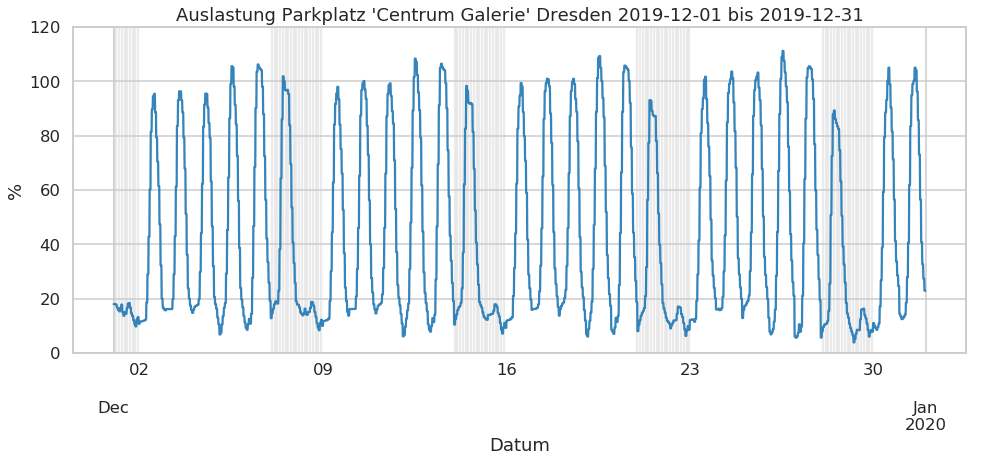

In [66]:
plotbelegung(future['Vorhersage'], name, '2019-12-01', '2019-12-31')
plt.savefig('%s-Belegung-Vorhersage-2019.png' % name, bbox_inches='tight', dpi=150)

### Save as .csv

In [67]:
future.dropna(inplace=True)
future['Vorhersage'].to_csv('%s-Belegung-Vorhersage-2019-15min.csv' % name,
                            header=False,
                            float_format='%i',
                            date_format ='%Y-%m-%dT%H:%M:%S')

Questions: [@Balzer82](https://twitter.com/Balzer82)